#isolation forest + ztest + optuna
기본적으로 베이스라인과 동일하게 아이솔레이션 포레스트 모델을 사용.
비지도 학습 시 zscore를 이용하여 중요한 feature만을 추출하고, 추출한 feature로 학습시키면 유용하다고 함. 따라서 Ztest 진행.
하이퍼 파라미터 튜닝을 위해 optuna 라이브러리 설치 후 사용

In [ ]:
#데이콘의 베이스 라인을 참고하여 필요한 라이브러리 임포트
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#csv 파일을 데이터 프레임 형태로 불러오기
train_df = pd.read_csv('/content/drive/MyDrive/데이콘-신용카드 사기 거래 탐지/train.csv')

In [ ]:
train_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


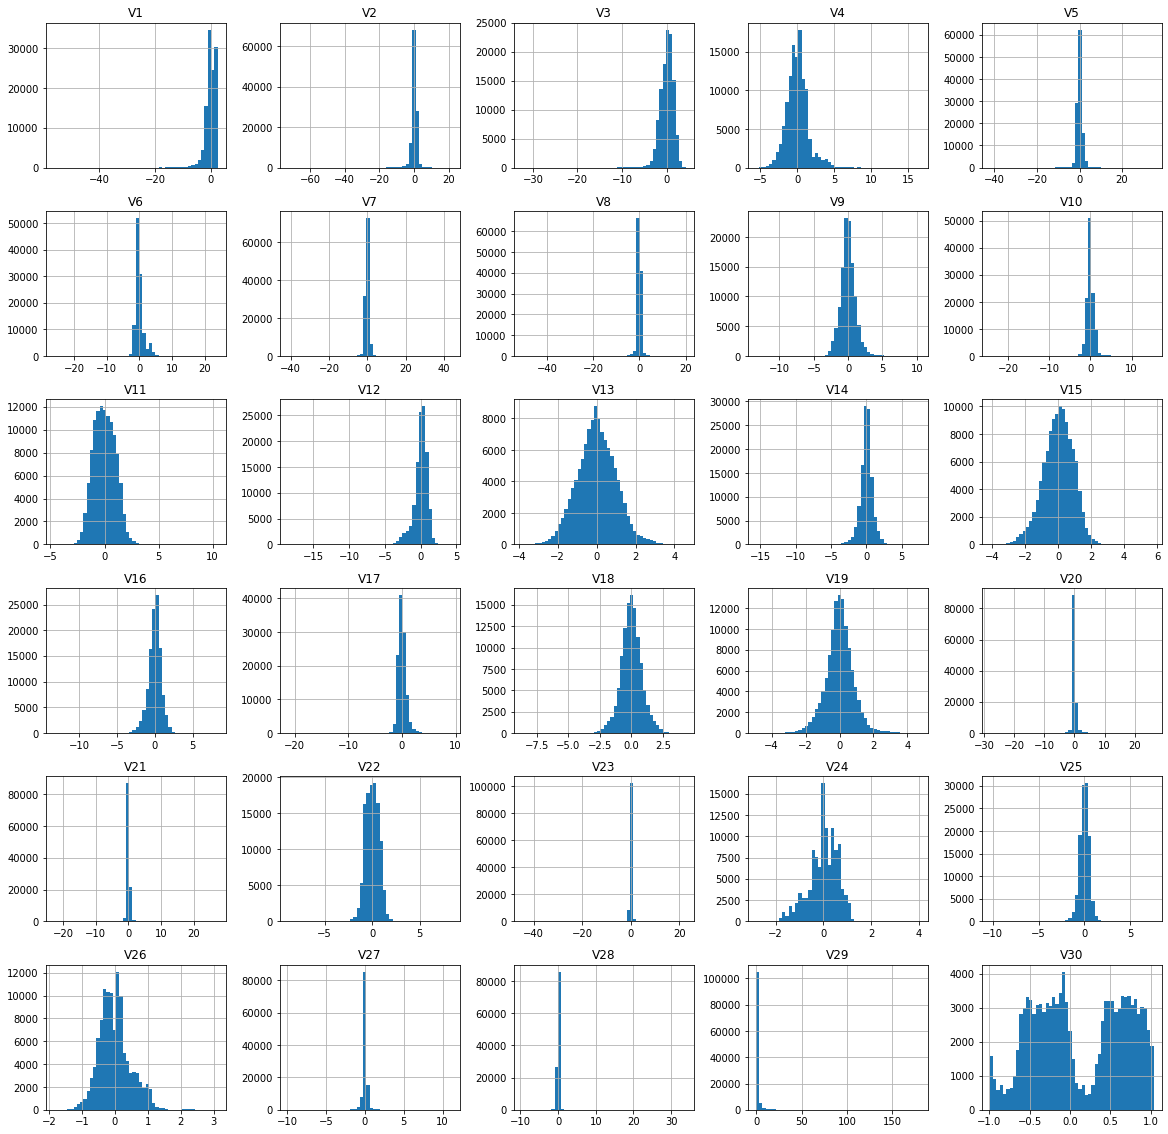

In [ ]:
#train_df에서 ID 정보만 드롭하고, 그 데이터로 히스토그램을 그려서 분포를 확인
train_df.drop(columns=["ID"]).hist(bins = 50, figsize = (20,20))
plt.show()

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/데이콘-신용카드 사기 거래 탐지/val.csv')

In [ ]:
val_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


In [ ]:
val_class = val_df['Class']
val_data = val_df.drop('ID', axis=1)
val_normal = val_data[val_data['Class']==0]
val_fraud = val_data[val_data['Class']==1]
cols = val_normal.columns[:-1]

In [ ]:
#Zscore를 이용해서 성능 향상
#비지도 학습 시 zscore가 낮은 feature의 경우 제거하여 학습하는 것이 좋은 경우 존재
def ztest(feature):
  mean = val_normal[feature].mean()
  std = val_fraud[feature].std()
  ZScore = (val_fraud[feature].mean()-mean)/(std/np.sqrt(len(val_fraud)))
  return ZScore

In [ ]:
significant_features = []
critical_value = 2.58

In [ ]:
for i in cols:
  z_value = ztest(i)
  print(i , ':' , z_value)
  if(abs(z_value) >= critical_value):
    significant_features.append(i)

V1 : -4.4526601182785885
V2 : 5.929642159946612
V3 : -5.995242925676357
V4 : 8.654554821045437
V5 : -3.963868977229947
V6 : -6.7752046847723415
V7 : -4.70856915422665
V8 : 1.4622168093026786
V9 : -6.912447203321289
V10 : -6.5941677253873205
V11 : 8.276193882145451
V12 : -7.584065293105052
V13 : 0.26576870038068195
V14 : -9.810267435198172
V15 : -1.238909416176234
V16 : -5.427457894138375
V17 : -5.2912452017598275
V18 : -4.083856057173998
V19 : 1.8508500185937453
V20 : 1.6346826520063453
V21 : -0.04789669313133748
V22 : 1.9696719953549637
V23 : 0.6086704108819003
V24 : -2.0021771832736293
V25 : -0.41281694889402665
V26 : 0.7658211283095404
V27 : -1.423458943056188
V28 : -1.5405432396419392
V29 : -0.5136414852625407
V30 : -1.5643607435994464


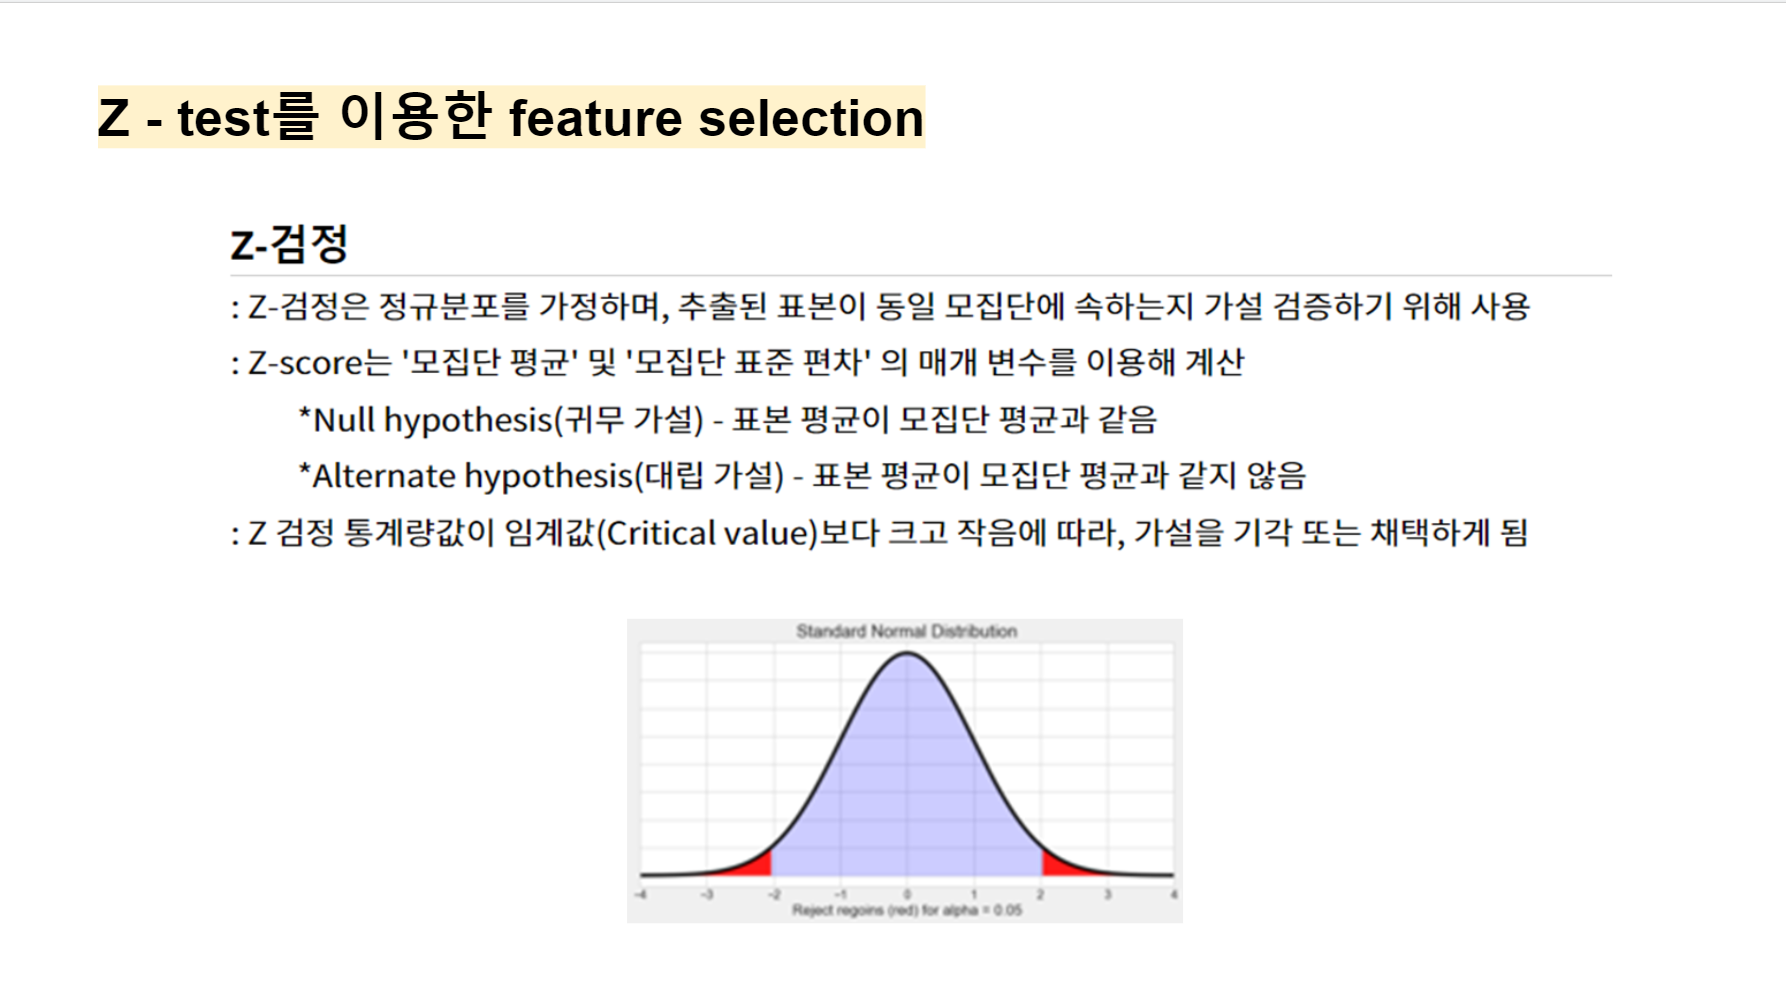

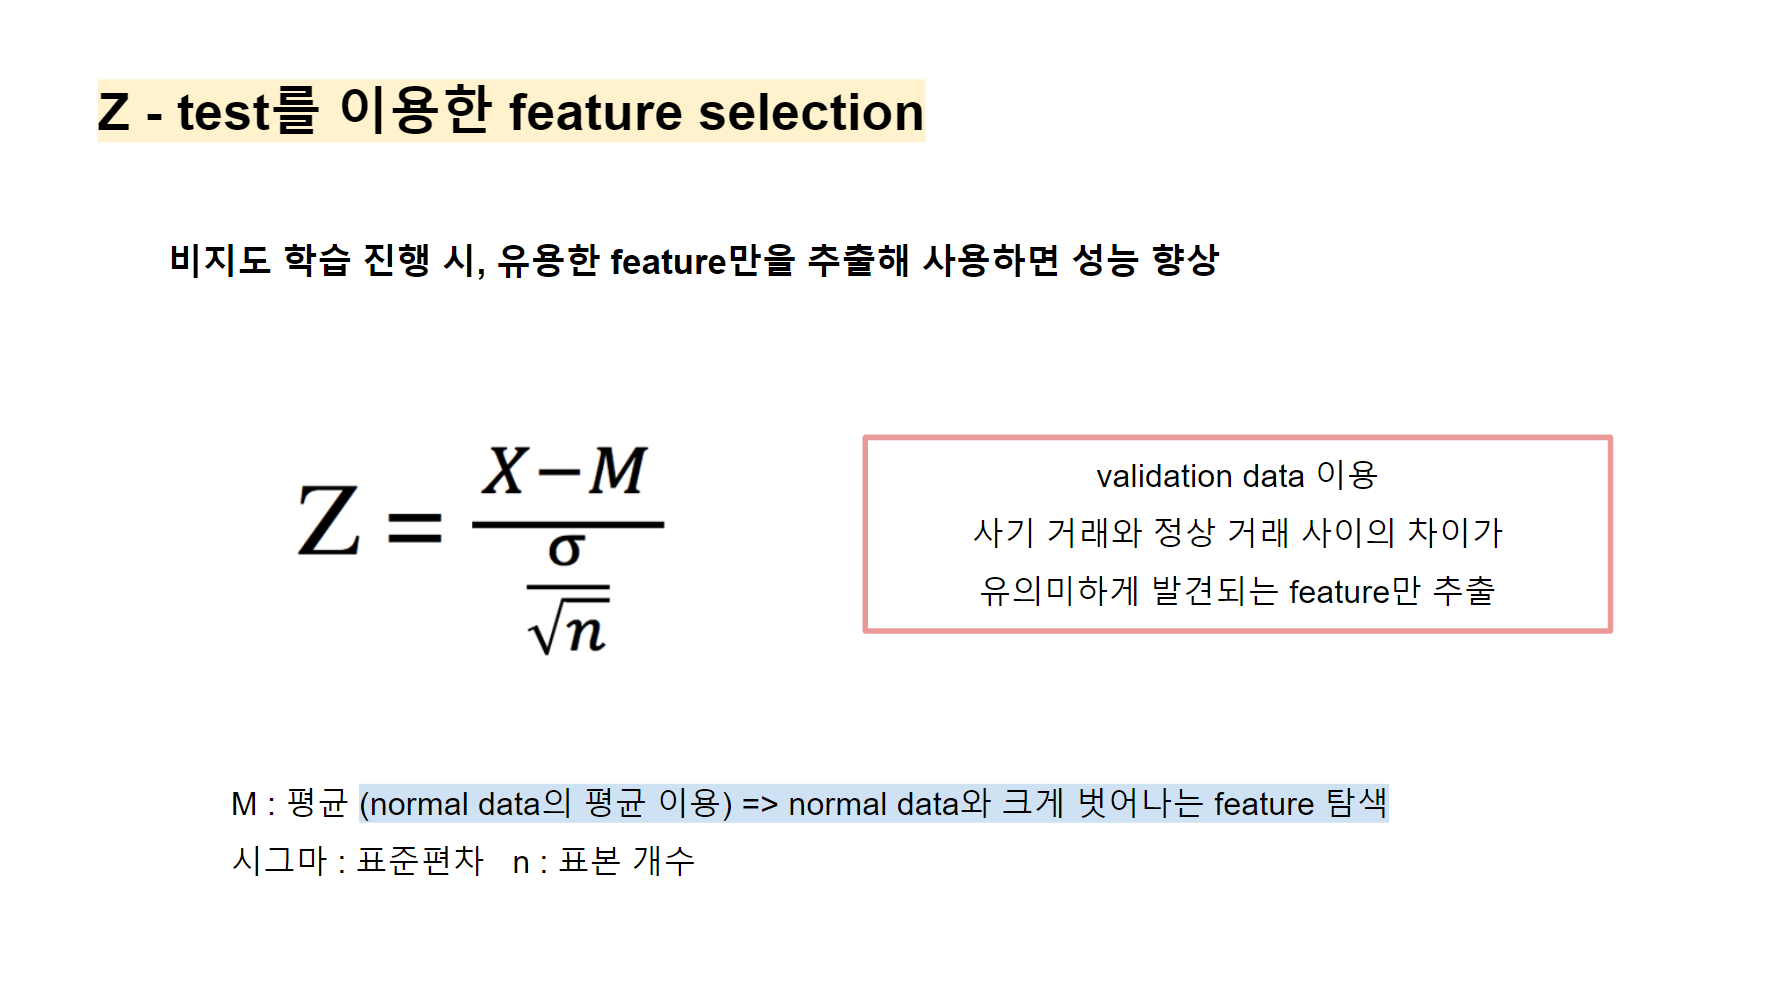

In [ ]:
print(significant_features)
#1~7, 9~12, 14, 16~18의 feature가 중요한 feature임을 확인할 수 있다.
#중요한 feature만을 추출해서 학습시켜본다.

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']


In [ ]:
train_sig = train_df.loc[:,['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']]

In [ ]:
val_sig = val_df.loc[:,['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18','Class']]

In [ ]:
train_sig.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,-0.568671,-0.371407,1.341262,0.359894,-0.137134,0.401726,-0.058133,0.068653
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,0.615375,1.249376,-0.619468,0.291474,-1.323865,-0.076127,-1.222127,-0.358222
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,-0.392048,-0.410430,-0.705117,-0.110452,0.074355,-0.210077,-0.499768,0.118765


In [ ]:
val_sig.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,-0.736727,-0.366846,1.017614,0.836390,-0.443523,0.739453,-0.540980,0.476677,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,-1.191311,0.724396,1.690330,0.406774,0.983739,-0.602232,0.402484,-1.737162,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.896287,0.757952,-0.448937,-0.660863,0.788864,0.295404,-0.287878,-0.451453,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.226278,-0.225495,1.944545,1.385160,0.314166,-1.333716,1.002869,-2.119314,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,4.009259,6.051521,2.572500,0.066851,-2.837136,-0.303774,-1.942303,-0.435450,0


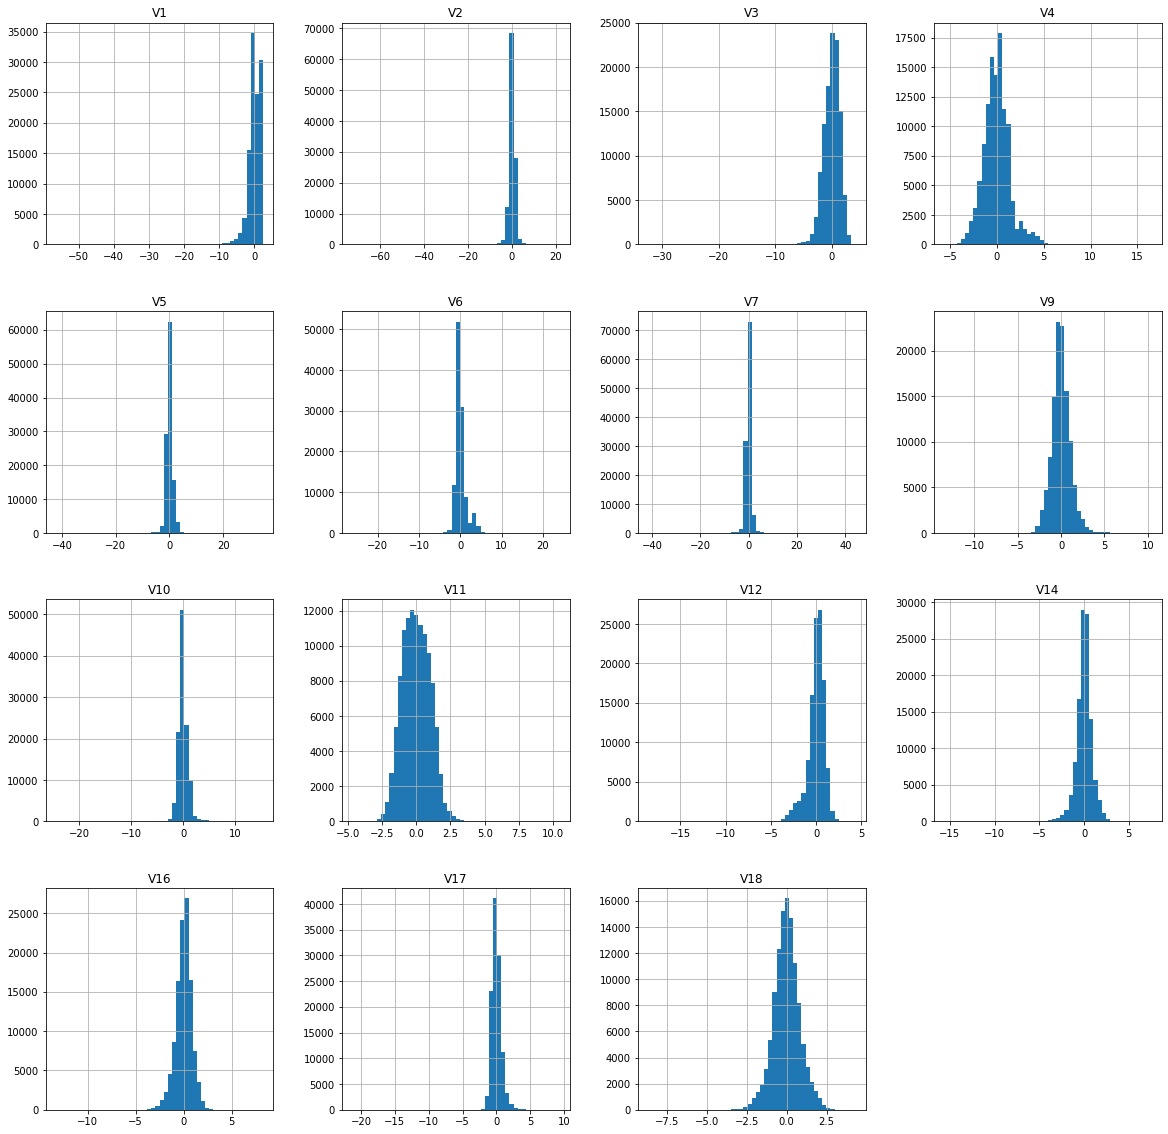

In [ ]:
train_sig.hist(bins = 50, figsize = (20,20))
plt.show()

In [ ]:
#아이솔레이션 포레스트 모델을 이용하려면 어느 정도의 수치까지 이상치로 분류할 것인지를 결정해야함.
#따라서 val_df의 사기 거래 비율을 계산하고, 그것을 이상치 정도로 잡기로 하자. (왜냐하면 우리는 사기 거래를 이상치라고 생각하고 탐지할 것이므로)

val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


In [ ]:
val_df['Class'].value_counts()
#0인 것은 normal한 것, 1인것은 fraud

0    28432
1       30
Name: Class, dtype: int64

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 12.7 MB/s 
     |████████████████████████████████| 209 kB 77.0 MB/s 
     |████████████████████████████████| 81 kB 11.5 MB/s 
     |████████████████████████████████| 78 kB 10.1 MB/s 
     |████████████████████████████████| 112 kB 78.0 MB/s 
     |████████████████████████████████| 49 kB 8.6 MB/s 
     |████████████████████████████████| 146 kB 93.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=bcf3fa218a507b168569d9dbc30f2097a830f0f54d7b8794f9576558169680f1
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

In [ ]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

* 아이솔레이션포레스트?
: 여러개의 의사결정나무를 종합한 앙상블 기반의 이상탐지기법. 의사결정 나무를 지속적으로 분기시키면서 모든 데이터 관측치의 고립 정도 여부에 따라 이상치를 판별하는 방법


비정상 데이터라면 의사 결정 나무의 루트에서 가까운 깊이에서 고립될 것이고 정상 데이터라면 먼 깊이에서 고립될 것.
-> 특정한 샘플이 고립되는 leaf 노드까지의 거리를 outlier score로 정의하고 루트 노드까지의 평균 거리가 짧을 수록 outlier score가 높아지는 원리

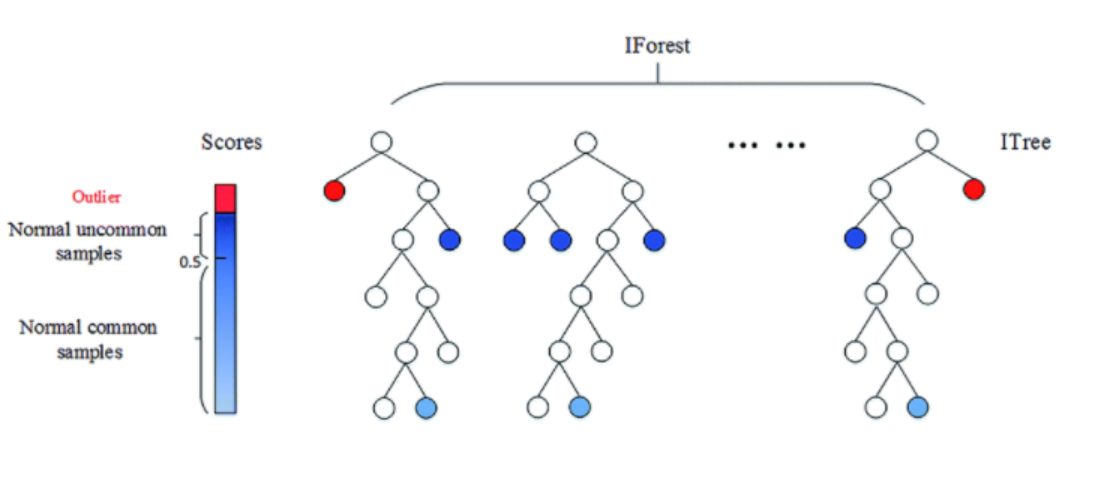

먼저 forest를 구성하는 여러 의사결정나무를 정의. 이때, 의사결정나무가 각각 서로 다른 데이터를 볼 수 있도록 각 의사결정나무마다 매번 전체 데이터에서 일부분을 샘플링한 데이터를 이용

각 나무에서는 분기에 사용할 변수를 랜덤하게 선택. 선택된 변수들의 값을 랜덤하게 분기하기 위해 해당 변수의 최소 / 최대 값 사이에 정의된 분포에서 샘플링하여 분기하게 됨. -> 최대 깊이에 도달할 때까지 지속적으로 분기

이상치 여부를 판단하기 위한 각 나무 별 데이터가 고립되기까지의 평균 길이 (depth) 계산

각 관측치마다 각 나무 별 이동 경로를 모든 나무에 대해서 계산

In [ ]:
def objective(trial):
  params = {
      "n_estimators" : trial.suggest_int("n_estimators", 50, 150),
      "max_samples" : len(train_sig),
      "max_features" : trial.suggest_int("max_features", 1, 10),
      "verbose" : 0,
      "contamination" : val_contamination,
      "random_state" : 42,
  }

  model = IsolationForest(**params)
  model_isolation = model.fit(train_sig)

  val_x = val_sig.drop(columns=['Class']) # Input Data
  val_y = val_sig['Class'] # Label

  val_pred = model_isolation.predict(val_x) # model prediction
  val_pred = get_pred_label(val_pred)
  val_score = f1_score(val_y, val_pred, average='macro')
  
  return val_score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
study.best_params

[I 2022-07-11 03:50:03,622] A new study created in memory with name: no-name-ded4a2f4-9583-42dc-b564-70182eacb48e
[I 2022-07-11 03:50:10,253] Trial 0 finished with value: 0.7255074821781313 and parameters: {'n_estimators': 74, 'max_features': 1}. Best is trial 0 with value: 0.7255074821781313.
[I 2022-07-11 03:50:15,983] Trial 1 finished with value: 0.7784511118613244 and parameters: {'n_estimators': 81, 'max_features': 7}. Best is trial 1 with value: 0.7784511118613244.
[I 2022-07-11 03:50:24,647] Trial 2 finished with value: 0.7578007195689396 and parameters: {'n_estimators': 118, 'max_features': 10}. Best is trial 1 with value: 0.7784511118613244.
[I 2022-07-11 03:50:32,691] Trial 3 finished with value: 0.7739473382643435 and parameters: {'n_estimators': 114, 'max_features': 5}. Best is trial 1 with value: 0.7784511118613244.
[I 2022-07-11 03:50:37,309] Trial 4 finished with value: 0.7456290543592985 and parameters: {'n_estimators': 63, 'max_features': 10}. Best is trial 1 with valu

{'max_features': 6, 'n_estimators': 50}

In [ ]:
model = IsolationForest(n_estimators=50, max_features=6, max_samples=len(train_sig), contamination=val_contamination, random_state=42, verbose=0)
model.fit(train_sig)

IsolationForest(contamination=0.0010551491277433877, max_features=6,
                max_samples=113842, n_estimators=50, random_state=42)

In [ ]:
val_x = val_sig.drop(columns=['Class']) # Input Data
val_y = val_sig['Class'] # Label

val_pred = model.predict(val_x) # model prediction
val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.7879157743510873]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.59      0.57      0.58        30

    accuracy                           1.00     28462
   macro avg       0.79      0.78      0.79     28462
weighted avg       1.00      1.00      1.00     28462



In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/데이콘-신용카드 사기 거래 탐지/test.csv') # Train
test_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,AAAA0x1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,AAAA0x2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,AAAA0x5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,AAAA0x7,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,AAAA0xc,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [ ]:
test_sig = test_df.loc[:,['ID','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']]

In [ ]:
test_x = test_sig.drop(columns=['ID'])

In [ ]:
test_pred = model.predict(test_x) # model prediction
test_pred = get_pred_label(test_pred)

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/데이콘-신용카드 사기 거래 탐지/sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [ ]:
submit['Class'] = test_pred
submit.to_csv('/content/drive/MyDrive/데이콘-신용카드 사기 거래 탐지/submit0711.csv', index=False)

#이외의 코드(스케일링 시도..)
캐글 코드를 보면 대부분 정규화하는 경우가 많아서 정규화를 시도해보았으나 오히려 정확도가 감소하는 것을 볼 수 있었다.

In [ ]:
#input 데이터셋을 만들어주기 위해 ID 컬럼을 드롭해준다.
train_x = train_df.drop(columns=['ID'])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x)
train_scaled = scaler.transform(train_x)

In [ ]:
train_scaled

array([[-0.69631739, -0.81248098,  1.17808885, ..., -0.16635528,
         1.18856304, -1.99083856],
       [-0.49535792, -0.11296695,  1.19130541, ...,  0.17399831,
         0.14387631, -1.99083856],
       [-0.21842739,  0.58098215,  0.75581873, ...,  0.22909822,
        -0.34673668, -1.99081751],
       ...,
       [-0.12409727,  0.4306078 ,  0.26059584, ...,  0.22961715,
        -0.33928516,  1.64589929],
       [ 0.06156632,  0.56310395, -0.37125132, ...,  0.19462489,
        -0.35074903,  1.64596243],
       [-6.08969719,  6.09942617, -6.57655196, ...,  2.31444543,
        -0.35860998,  1.64598348]])

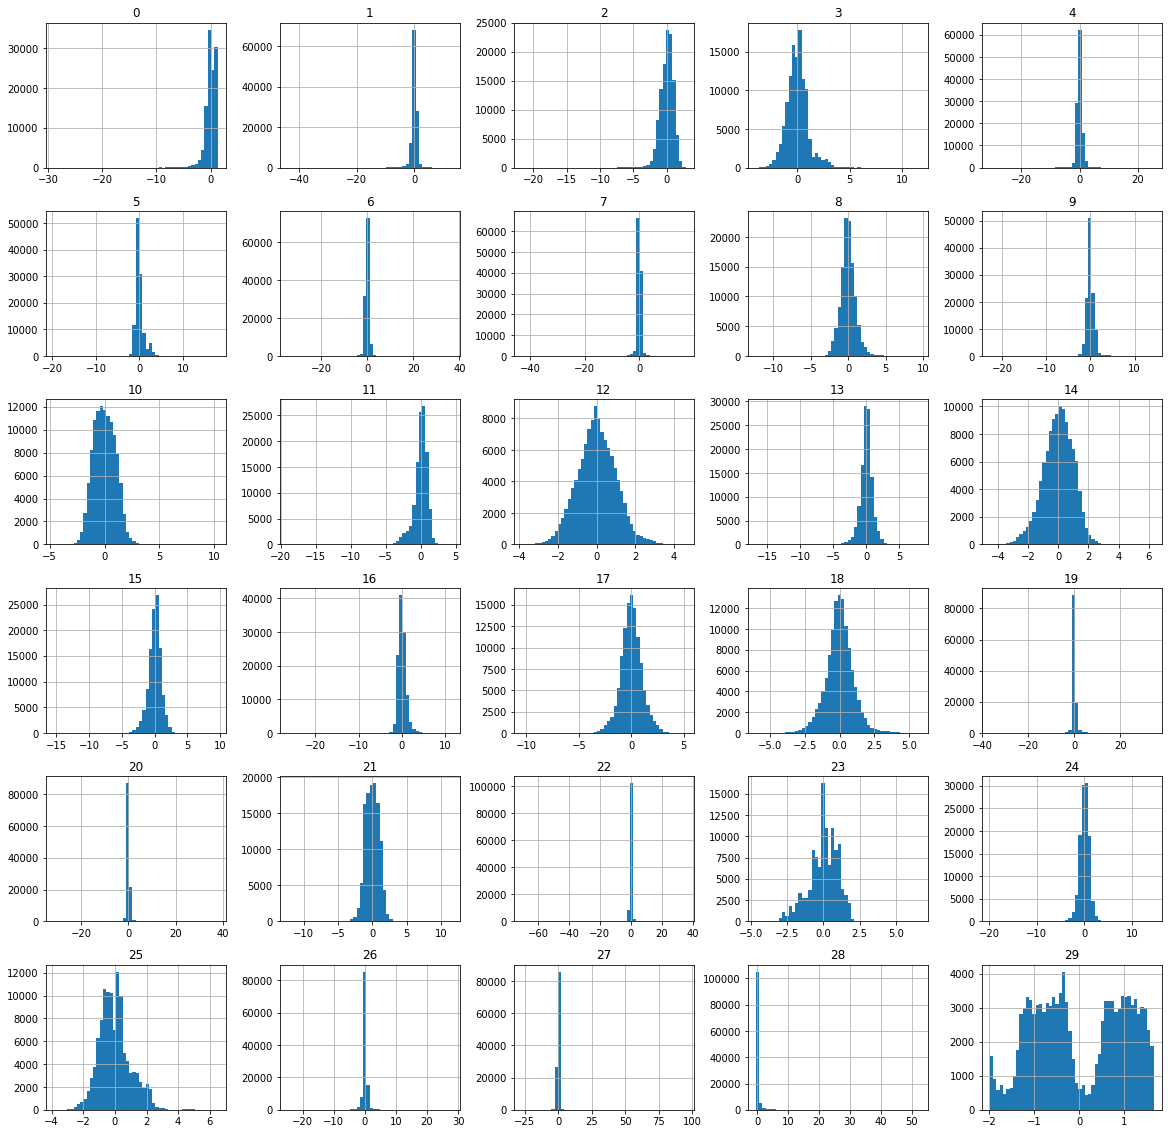

In [ ]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.hist(bins = 50, figsize = (20,20))
plt.show()

In [ ]:
model = IsolationForest(n_estimators=125, max_samples=len(train_x), contamination=val_contamination, random_state=42, verbose=0)
model.fit(train_scaled)

IsolationForest(contamination=0.0010551491277433877, max_samples=113842,
                n_estimators=125, random_state=42)

In [ ]:
val_x = val_df.drop(columns=['ID', 'Class']) # Input Data
val_y = val_df['Class'] # Label

val_pred = model.predict(val_x) # model prediction
val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.6901332489169495]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.36      0.40      0.38        30

    accuracy                           1.00     28462
   macro avg       0.68      0.70      0.69     28462
weighted avg       1.00      1.00      1.00     28462

